In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import uproot
import logging

In [2]:
hits = uproot.open("../10events/hits.root:hits").arrays(library="pd")
hits = hits[ (hits.event_id == 0) & (hits.tt < 25.0) ].copy()
hits["hit_id"] = np.arange(len(hits))
hitId_to_particleId = dict(zip(hits.hit_id, hits.particle_id))

simhit_map = pd.read_csv("../output/gnn_ckf_no_threshold/digi/event000000000-measurement-simhit-map.csv")
measId_to_hitID = dict(zip(simhit_map.measurement_id, simhit_map.hit_id))

In [3]:
matches_gnn_plus_ckf = pd.read_csv("../output/gnn_ckf_no_threshold/performance_gnn_plus_ckf.csv")
matches_gnn_plus_ckf = matches_gnn_plus_ckf[ matches_gnn_plus_ckf.event == 0 ]
prototracks_gnn_plus_ckf = pd.read_csv("../output/gnn_ckf_no_threshold/gnn_plus_ckf/event000000000-prototracks.csv")
prototracks_gnn_plus_ckf["hit_id"] = prototracks_gnn_plus_ckf["measurementId"].map(measId_to_hitID)
prototracks_gnn_plus_ckf["particle_id"] = prototracks_gnn_plus_ckf.hit_id.map(hitId_to_particleId)

In [4]:
sum(matches_gnn_plus_ckf.matched), sum(np.logical_not(matches_gnn_plus_ckf.matched))

(2387, 208)

In [5]:
matches_proof_of_concept = pd.read_csv("../output/gnn_ckf_no_threshold/performance_proof_of_concept.csv")
matches_proof_of_concept = matches_proof_of_concept[ matches_proof_of_concept.event == 0 ]
prototracks_proof_of_concept = pd.read_csv("../output/gnn_ckf_no_threshold/proof_of_concept/event000000000-prototracks.csv")
prototracks_proof_of_concept["hit_id"] = prototracks_proof_of_concept["measurementId"].map(measId_to_hitID)
prototracks_proof_of_concept["particle_id"] = prototracks_proof_of_concept.hit_id.map(hitId_to_particleId)

In [6]:
sum(matches_proof_of_concept.matched), sum(np.logical_not(matches_proof_of_concept.matched))

(2713, 17)

In [7]:
prototracks_proof_of_concept.shape, prototracks_gnn_plus_ckf.shape

((16376, 7), (29825, 7))

In [8]:
test_pid = matches_gnn_plus_ckf[ matches_gnn_plus_ckf.matched == 0 ]["particle_id"].to_numpy()[0]

In [9]:
prototracks_gnn_plus_ckf[ prototracks_gnn_plus_ckf.particle_id == test_pid ]

,trackId,measurementId,x,y,z,hit_id,particle_id
4499,688,24787,-5.865470,31.479707,121.704681,24794,4503599811919872
4500,688,25647,-6.159220,33.203372,126.914408,25654,4503599811919872
4502,688,38870,-11.837094,67.356497,229.971654,38880,4503599811919872
4503,688,40056,-18.303795,112.239380,364.746514,40068,4503599811919872


In [10]:
prototracks_proof_of_concept[ prototracks_proof_of_concept.particle_id == test_pid ]

,trackId,measurementId,x,y,z,hit_id,particle_id
47,7,24787,-5.865470,31.479707,121.704681,24794,4503599811919872
48,7,25647,-6.159220,33.203372,126.914408,25654,4503599811919872
49,7,38870,-11.837094,67.356497,229.971654,38880,4503599811919872
50,7,40056,-18.303795,112.239380,364.746514,40068,4503599811919872


In [11]:
equal = []

for pid in matches_gnn_plus_ckf[ matches_gnn_plus_ckf.matched == 0 ]["particle_id"]:
    test = prototracks_gnn_plus_ckf[ prototracks_gnn_plus_ckf.particle_id == pid ]
    ref = prototracks_proof_of_concept[ prototracks_proof_of_concept.particle_id == pid ]

    if len(test) == len(ref): 
        equal.append(all(test.measurementId.to_numpy() == ref.measurementId.to_numpy()))
    else:
        equal.append(False)

In [12]:
sum(equal)/len(equal)

0.6682692307692307

In [13]:
sum(equal)

139

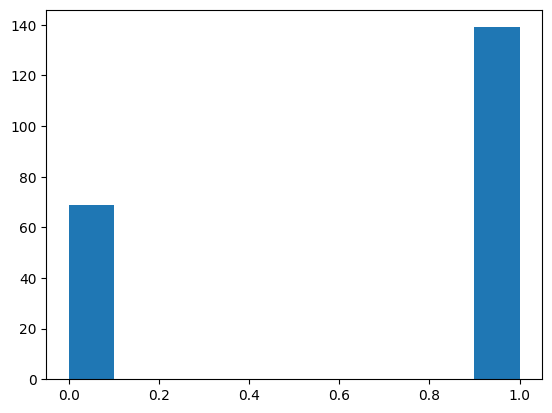

In [14]:
_ = plt.hist(np.array(equal).astype(int))

In [15]:
parameters_gnn_plus_ckf = pd.read_csv("../output/gnn_ckf_no_threshold/gnn_plus_ckf/event000000000-parameters")
len(parameters_gnn_plus_ckf), len(np.unique(prototracks_gnn_plus_ckf.trackId))

(4910, 4910)

In [16]:
parameters_proof_of_concept = pd.read_csv("../output/gnn_ckf_no_threshold/proof_of_concept/event000000000-parameters")
len(parameters_proof_of_concept), len(np.unique(prototracks_proof_of_concept.trackId))

(2787, 2787)

In [35]:
gnn_plus_ckf_dict = { 
    sum(t.measurementId): (p, t.sort_values("hit_id")) 
    for (_, t), (_, p) in zip(prototracks_gnn_plus_ckf.groupby("trackId"), parameters_gnn_plus_ckf.iterrows())
}

In [36]:
proof_of_concept_dict = { 
    sum(t.measurementId): (p, t.sort_values("hit_id")) 
    for (_, t), (_, p) in zip(prototracks_proof_of_concept.groupby("trackId"), parameters_proof_of_concept.iterrows())
}

In [37]:
common_keys = np.intersect1d(list(gnn_plus_ckf_dict.keys()), list(proof_of_concept_dict.keys()))
len(common_keys)

2132

In [38]:
gnn_plus_ckf_dict[common_keys[0]][1]

,trackId,measurementId,x,y,z,hit_id,particle_id
25190,4048,103,62.668619,13.297949,-1516.8,103,310748374355673088
25189,4048,2442,54.192461,11.285588,-1316.8,2443,310748374355673088
25188,4048,4750,45.622567,9.299874,-1116.8,4751,310748374355673088


In [39]:
proof_of_concept_dict[common_keys[0]][1]

,trackId,measurementId,x,y,z,hit_id,particle_id
6346,1099,103,62.668619,13.297949,-1516.8,103,310748374355673088
6347,1099,2442,54.192461,11.285588,-1316.8,2443,310748374355673088
6348,1099,4750,45.622567,9.299874,-1116.8,4751,310748374355673088


In [42]:
gnn_plus_ckf_dict[common_keys[0]][0][:5]

d0        2.825001
z0      -29.525000
phi       0.224973
theta     3.097849
qop      -0.045028
Name: 4048, dtype: float64

In [43]:
proof_of_concept_dict[common_keys[0]][0][:5]

d0        2.825001
z0      -29.525000
phi       0.224973
theta     3.097849
qop      -0.045028
Name: 1099, dtype: float64